# Wind Turbine Maintenance Optimization

There are 7 wind turbines, which all need to be maintained once during the week. There are two maintenance teams: maintenance team 1 and maintenance team 2. There is no difference between the two maintenance teams.

The maintenance teams only work on workdays, i.e. from Monday to Friday. It takes one maintenance team a full day to maintain one wind turbine. Due to different locations of each wind turbine and the weather of the date, the maintenance costs are different. The costs are the costs are the same for both maintenance teams.

The costs are stated in the following table:

$$
\begin{array}{c|ccccc}
\textbf{turbine} & \textbf{Mon} & \textbf{Tue} & \textbf{Wed} & \textbf{Thu} & \textbf{Fri} \\
\hline
1 & 10 & 11 & 12 & 13 & 14 \\
2 & 12 & 14 & 16 & 18 & 20 \\
3 & 17 & 18 & 17 & 18 & 17 \\
4 & 20 & 19 & 18 & 17 & 16 \\
5 & 22 & 22 & 22 & 22 & 33 \\
6 & 24 & 23 & 22 & 23 & 23 \\
7 & 9  & 6  & 8  & 7  & 9  \\
\end{array}
$$

Formulate an integer linear model to minimize the maintenance cost (and eventually solve it numerically).

## Proposed solution
Before implementing the optimization model in PuLP, it is useful to describe clearly the mathematical structure of the problem we want to solve. The scenario is the following: we have 7 wind turbines, each of which must receive exactly one maintenance operation during the week, and we have two identical maintenance teams available. Each maintenance activity takes a full day, and the maintenance costs vary depending on both the turbine and the day of the week, mainly due to geographical and weather-related factors.

A suggested integer programming formulation is as follows:

Before implementing the model in PuLP, a suggested integer programming formulation used to represent the maintenance scheduling problem.

We consider three index sets:

- $\mathcal{T} := \{i \mid i \in \{ 1, \ldots, 7 \} \}$: the set of wind turbines,
- $\mathcal{D} := \{j \mid j \in \{ \text{Mon}, \dots, \text{Fri} \}$: the set of different days,
- $\mathcal{K} := \{k \mid k \in \{ 1, 2 \} \}$: the set of two maintenance teams.

The maintenance cost of servicing turbine $i$ on day $j$ is denoted by $c_{ij}$.
Since both teams are identical in cost, the index $k$ does not appear in the parameters.

The decision variables are:

$$ x_{i,j,k} = \begin{cases} 1 & \text{if maintenance team } k \in \mathcal{K} \text{ maintain wind turbine } i \in \mathcal{T} \text{ at day } j \in \mathcal{D}, \\ 0 & \text{otherwise}  \end{cases} $$

These binary variables encode all possible assignments of turbines to days and teams.

The goal is to minimize the total maintenance cost for the entire week:

$$ \sum_{i \in \mathcal{T}} \sum_{j \in \mathcal{D}} \sum_{k \in \mathcal{K}} c_{ij} x_{ijk} $$

Even though $c_{ij}$ does not depend on $k$, the summation includes all teams because the decision variables are indexed over $k$.

The constraints of the model are as follows:

$$ \begin{cases}  \displaystyle{ \sum_{j \in \mathcal{D}} \sum_{k \in \mathcal{K}}} x_{ijk} = 1 & i \in \mathcal{T} \\ \displaystyle{\sum_{i \in \mathcal{D}}} x_{ijk} \leq 1 & k \in \mathcal{K}, j \in \mathcal{D}, \\ x_{ijk} \in \{ 0, 1 \} & i \in \mathcal{T}, j \in \mathcal{D}, k \in \mathcal{K} \end{cases} $$

where the first constraint ensures that each turbine is maintained exactly once during the week, and the second constraint ensures that each maintenance team can work on at most one turbine per day. The binary nature of the decision variables is enforced by the last constraint.

## Importing required packages
We start by installing the required packages and importing them into the notebook. We will use NumPy for defining the costs matrix and PuLP for formulating and solving the integer linear programming model.

In [1]:
!pip install -r requirements.txt
import numpy as np
import pulp as pl
import matplotlib.pyplot as plt
import seaborn as sns

## Definition of Index Sets

In this block we define the index sets used in the Integer Linear Programming (ILP) model:

- $\mathcal{T} := \{i \mid i \in \{ 1, \ldots, 7 \} \}$: the set of wind turbines,
- $\mathcal{D} := \{j \mid j \in \{ \text{Mon}, \dots, \text{Fri} \}$: the set of different days, indexed from $1$ (Mon) to $5$ (Fri),
- $\mathcal{K} := \{k \mid k \in \{ 1, 2 \} \}$: the set of two identical maintenance teams.

In [2]:
turbines = range(1, 8)  # From 1 to 7
days = range(1, 6)      # From 1 (Mon) to 5 (Fri)
teams = [1, 2]

## Maintenance Costs
In this block we define the maintenance costs matrix, where `costs[i-1, j-1]` corresponds to the cost $c_{ij}$ of maintaining turbine $i$ on day $j$. This matrice `costs` $\in \mathbb{R}^{7 \times 5}$ is the original data provided in the problem statement.

However, in the linear programming notation, the objective function is written as:
$$ \text{min} \ \boldsymbol{c}^\top \boldsymbol{x} $$

where neither $\boldsymbol{c}$ nor $\boldsymbol{x}$ are matrices. Instead, both $\boldsymbol{c}$ and $\boldsymbol{x}$ are flattened into vectors.

Each cost value $c_{ij}$ is duplicated for every team $k \in \{ 1, 2 \}$, since both maintenance teams have identical costs.

Thus, the true cost vector in the linear algebra formulation is:
$$ \boldsymbol{c} = \begin{pmatrix} c_{1 \text{Mon}} \\ c_{1 \text{Mon}} \\  c_{1 \text{Tue}} \\ c_{1 \text{Tue}} \\ \ldots \\ c_{7 \text{Fri}} \\ c_{7 \text{Fri}} \end{pmatrix} \in \mathbb{R}^{70} $$

In [3]:
costs = np.array([
    # Mon, Tue, Wed, Thu, Fri
    [10, 11, 12, 13, 14],  # Turbine 1
    [12, 14, 16, 18, 20],  # Turbine 2
    [17, 18, 17, 18, 17],  # Turbine 3
    [20, 19, 18, 17, 16],  # Turbine 4
    [22, 22, 22, 22, 33],  # Turbine 5
    [24, 23, 22, 23, 23],  # Turbine 6
    [9,  6,  8,  7,  9]    # Turbine 7
])

print("Costs matrix shape:", costs.shape)

Costs matrix shape: (7, 5)


## Visualizing the Maintenance Costs
The heatmap on the left provides a quick overview of maintenance costs for each turbine across the week. We can observe that Turbine 5 has a significant cost spike on Friday, while turbines like 1 and 2 show steadily increasing costs as the week progresses. Turbine 7, in contrast, maintains consistently low costs throughout the week.

The line plot on the right highlights the cost trends per turbine. Some turbines follow clear monotonic patterns—for instance, Turbine 1’s cost increases each day, while Turbine 4’s cost decreases over the week. Others, such as Turbine 3 and 6, fluctuate mildly around a stable range. Together, these plots help identify which turbines are more cost-sensitive to the choice of maintenance day and where the optimization model has the greatest flexibility or constraints.

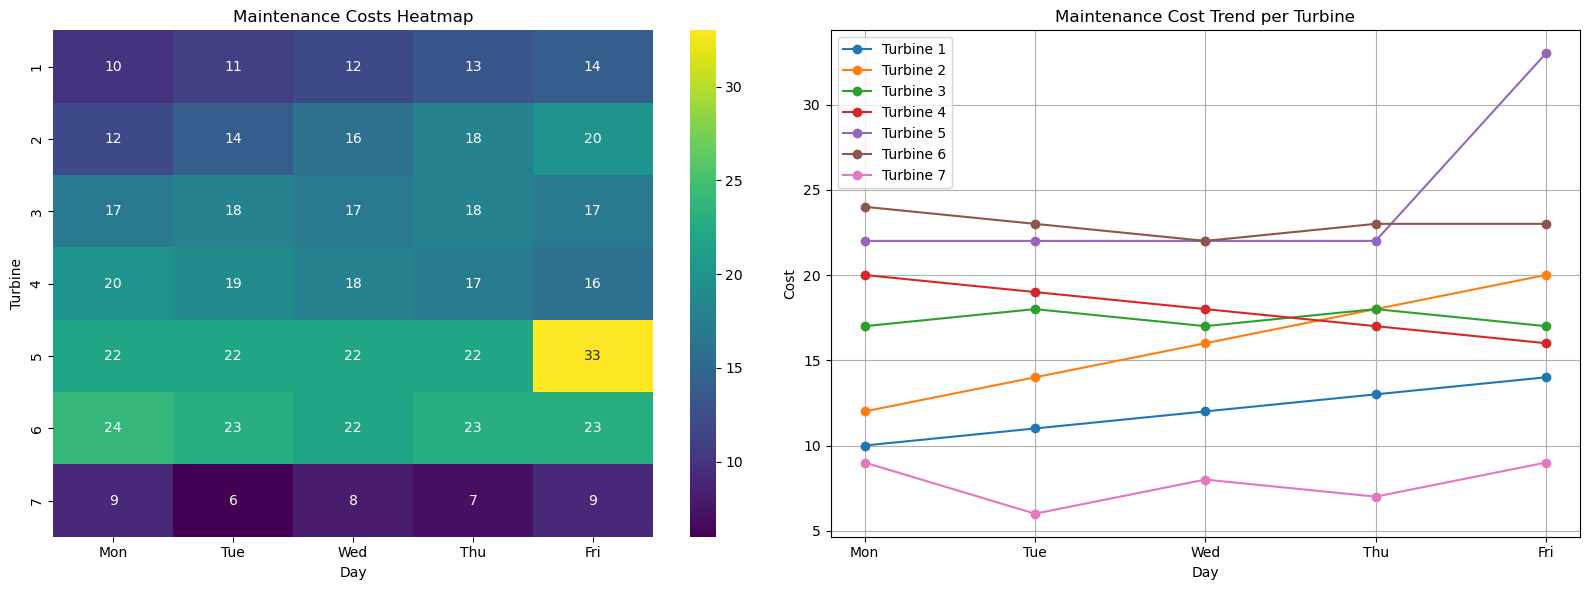

In [21]:
day_labels = ["Mon","Tue","Wed","Thu","Fri"]

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Left subplot: Heatmap ---
sns.heatmap(costs, annot=True, cmap="viridis",
            xticklabels=day_labels, yticklabels=turbines,
            ax=axes[0])
axes[0].set_title("Maintenance Costs Heatmap")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Turbine")

# --- Right subplot: Line trends ---
for i in range(costs.shape[0]):
    axes[1].plot(day_labels, costs[i], marker="o", label=f"Turbine {i+1}")

axes[1].set_title("Maintenance Cost Trend per Turbine")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Cost")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Binary Decision Variables
This cell defines the binary decision variables $x_{ijk}$, where:

$$ x_{i,j,k} = \begin{cases} 1 & \text{if maintenance team } k \in \mathcal{K} \text{ maintain wind turbine } i \in \mathcal{T} \text{ at day } j \in \mathcal{D}, \\ 0 & \text{otherwise}  \end{cases} $$

Pulp's `LpVariable.dicts` function is used to create a compact three-dimensional dictionary of binary variables indexed by turbines, days, and teams. Setting `lowBound = 0`, `upBound = 1`, and `cat = pl.LpBinary` ensures that the variables are binary ($0$ or $1$).

In [4]:
x = pl.LpVariable.dicts(
    "x",
    (turbines, days, teams),
    lowBound = 0,
    upBound = 1,
    cat = pl.LpBinary
)

print("Variable for maintained turbine 1 on Wednesday by Team 2:", x[1][3][2])
print("Total decision variables:", len(x) * len(days) * len(teams))

Variable for maintained turbine 1 on Wednesday by Team 2: x_1_3_2
Total decision variables: 70


## Initialization of the Boolean Integer Linear Programming model
This cell initializes the main optimization model: a Boolean Integer Linear Programming (BILP) problem with a minimization objective.

I am aiming to the mathematical formulation
$$ \text{min} \ \boldsymbol{c}^\top \boldsymbol{x} $$

In [5]:
lp_prob = pl.LpProblem("Wind_Turbine_Maintenance_Optimization", pl.LpMinimize)

## Objective Function
This cell defines the objective function of the optimization model, aiming to minimize the total maintenance cost.

Each term of the objective is given by the product of the cost $c_{ij}$ for turbine $i$ on day $j$ and the binary decision variable $x_{ijk}$, which indicates whether team $k$ performs maintenance on that turbine on that day.

The `lpSum` function from the PuLP library is used to compactly constructs the triple summation over turbines, days, and teams.

Note that the index $k$ appears in the triple summation even though it does not directly affect the cost term, because **both maintenance teams have identical costs**. However, since the decision variable $x_{ijk}$ depends on $k$ because are defined on the full domain $\mathcal{T} \times \mathcal{D} \times \mathcal{K}$, the objective function must sum over all indices.

Finally, the expression

$$ \sum_{i \in \mathcal{T}} \sum_{j \in \mathcal{D}} \sum_{k \in \mathcal{K}} c_{ij} x_{ijk} $$

corresponds to the linear algebra formulation seen during lectures:

$$ \text{min} \ \boldsymbol{c}^\top \boldsymbol{x} $$

In [6]:
lp_prob += pl.lpSum(
    costs[i-1, j-1] * x[i][j][k]
    for i in turbines
    for j in days
    for k in teams
)

## Constraints
This section introduces the key constraints of the integer linear programming model.
The first constraint ensures that **each turbine is maintained exactly once during the week**, regardless of which team performs the operation or on which day. This is enforced by summing the decision variables over all days and teams.

The second constraint ensures that **each maintenance team can work on at most one turbine per day**, since a full-day maintenance operation cannot be shared. Therefore, the sum of all variables corresponding to the same $(j, k)$ pair must not exceed $1$.

These constraints match the theoretical formulation:

$$ \begin{cases}  \displaystyle{ \sum_{j \in \mathcal{D}} \sum_{k \in \mathcal{K}}} x_{ijk} = 1 & i \in \mathcal{T} \\ \displaystyle{\sum_{i \in \mathcal{T}}} x_{ijk} \leq 1 & k \in \mathcal{K}, j \in \mathcal{D}, \\ x_{ijk} \in \{ 0, 1 \} & i \in \mathcal{T}, j \in \mathcal{D}, k \in \mathcal{K} \end{cases} $$

The total number of constraints is $17$ because:
- The first constraint generates $7$ equations (one for each turbine),
- The second constraint generates $5 \times 2 = 10$ inequalities, one for each combination of day and team.

In [7]:
# 1) Each turbine is maintained exactly once during the week
for i in turbines:
    lp_prob += pl.lpSum(x[i][j][k] for j in days for k in teams) == 1, f"one_maintenance_turbine_{i}"

# 2) Each team can work on at most one turbine per day
for j in days:
    for k in teams:
        lp_prob += pl.lpSum(x[i][j][k] for i in turbines) <= 1, f"capacity_team_{k}_{j}"

print("Number of constraints:", len(lp_prob.constraints))
lp_prob.constraints

Number of constraints: 17


{'one_maintenance_turbine_1': 1*x_1_1_1 + 1*x_1_1_2 + 1*x_1_2_1 + 1*x_1_2_2 + 1*x_1_3_1 + 1*x_1_3_2 + 1*x_1_4_1 + 1*x_1_4_2 + 1*x_1_5_1 + 1*x_1_5_2 + -1.0 = 0,
 'one_maintenance_turbine_2': 1*x_2_1_1 + 1*x_2_1_2 + 1*x_2_2_1 + 1*x_2_2_2 + 1*x_2_3_1 + 1*x_2_3_2 + 1*x_2_4_1 + 1*x_2_4_2 + 1*x_2_5_1 + 1*x_2_5_2 + -1.0 = 0,
 'one_maintenance_turbine_3': 1*x_3_1_1 + 1*x_3_1_2 + 1*x_3_2_1 + 1*x_3_2_2 + 1*x_3_3_1 + 1*x_3_3_2 + 1*x_3_4_1 + 1*x_3_4_2 + 1*x_3_5_1 + 1*x_3_5_2 + -1.0 = 0,
 'one_maintenance_turbine_4': 1*x_4_1_1 + 1*x_4_1_2 + 1*x_4_2_1 + 1*x_4_2_2 + 1*x_4_3_1 + 1*x_4_3_2 + 1*x_4_4_1 + 1*x_4_4_2 + 1*x_4_5_1 + 1*x_4_5_2 + -1.0 = 0,
 'one_maintenance_turbine_5': 1*x_5_1_1 + 1*x_5_1_2 + 1*x_5_2_1 + 1*x_5_2_2 + 1*x_5_3_1 + 1*x_5_3_2 + 1*x_5_4_1 + 1*x_5_4_2 + 1*x_5_5_1 + 1*x_5_5_2 + -1.0 = 0,
 'one_maintenance_turbine_6': 1*x_6_1_1 + 1*x_6_1_2 + 1*x_6_2_1 + 1*x_6_2_2 + 1*x_6_3_1 + 1*x_6_3_2 + 1*x_6_4_1 + 1*x_6_4_2 + 1*x_6_5_1 + 1*x_6_5_2 + -1.0 = 0,
 'one_maintenance_turbine_7': 1*x_7_1_1 

## Solving the Model

In this cell the model is solved using the CBC solver, which relies on Branch & Cut rather than the classical Branch & Bound.
Pure Branch & Bound explores the search tree without modifying the LP relaxation and can therefore be relatively slow.

CBC improves efficiency by:
- adding cutting planes, which tighten the LP relaxation and move it closer to the integer feasible region. This removes many fractional solutions before branching and reduces the size of the search tree;
- using heuristics that quickly build “good” integer solutions, improving the upper bound early.

Finally, the solver status is printed and it is Optimal, meaning that a valid optimal solution has been found.

The most common solver statuses are:
- **Optimal**: a valid optimal solution was found
- **Infeasible**: no feasible solution satisfies all constraints
- **Unbounded**: the model is not bounded below
- **Not Solved**: the solver did not converge due to time limits or numerical instability

In [8]:
lp_prob.solve(pl.PULP_CBC_CMD())
print("Status:", pl.LpStatus[lp_prob.status])

Status: Optimal


## Displaying the optimal solution

This cell extracts the optimal schedule returned by the solver and prints, for each turbine, the assigned day and team.
Since the decision variables $x_{ijk}$ are binary, each turbine appears exactly once in the printed output, consistently with the coverage constraint.

The `day_labels` array maps numerical day indices to readable labels (Mon–Fri).
At the end, the total optimal cost is displayed by evaluating the objective function at the optimal solution.

This output allows us to verify that:
- each turbine is scheduled exactly once;
- no team performs more than one maintenance task per day;
- the schedule corresponds to the minimum-cost feasible assignment.

In [9]:
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri"]

for i in turbines:
    for j in days:
        for k in teams:
            if pl.value(x[i][j][k]) == 1:
                print(f"Turbine {i} maintained on {day_labels[j-1]} by Team {k}")
print("Total optimal cost", pl.value(lp_prob.objective))

Turbine 1 maintained on Mon by Team 1
Turbine 2 maintained on Mon by Team 2
Turbine 3 maintained on Wed by Team 2
Turbine 4 maintained on Fri by Team 1
Turbine 5 maintained on Tue by Team 1
Turbine 6 maintained on Wed by Team 1
Turbine 7 maintained on Tue by Team 2
Total optimal cost 105.0


## Gantt Chart of the Optimal Maintenance Schedule
The Gantt chart provides an intuitive overview of the maintenance assignments, allowing for quick assessment of team workloads and scheduling efficiency.

<div style="text-align: center;">
<img src="data/figs/gantt.png" alt="Gantt chart of the optimal maintenance schedule" width="450"/>
</div>

The chart uses horizontal bars to indicate which turbine is being maintained on each day by each team. Different colors are used for the two maintenance teams to enhance clarity.